# Automatic coastal vegetation edge detection

## Context
Coastal communities, land covers, and intertidal habitats are vulnerable receptors of erosion, flooding or both in combination. This vulnerability is likely to increase with sea level rise and greater storminess over future decadal-scale time periods [(Rogers et al., 2021)](https://www.tandfonline.com/doi/abs/10.1080/01431161.2021.1897185?journalCode=tres20).

`VEdge_Detector` is a python-based tool for the automated detection of coastal vegetation edges in remote sensing imagery. The tool produces a heatmap, showing the pixels predicted with the highest confidence as being the vegetation line (Figure 1).

<img src="https://github.com/MartinSJRogers/VEdge_Detector/blob/907ed83096570b87dcd211384c697d51097f3872/example_Images.png?raw=true" width="600">

**Figure 1** Outputs produced by the `VEdge_Detector` model in A) Suffolk, United Kingdom; B) Wilk auf Föhr, Germany and C) Varela, Guinea Bissau. Source: [Rogers (2021)](https://github.com/MartinSJRogers/VEdge_Detector).

The `VEdge_Detector` model was trained using Planet 3 – 5 m spatial resolution imagery. It has also detected vegetation edges in Landsat and Copernicus imagery, although performance is not guaranteed. The tool cannot detect the vegetation edge in aerial imagery.

<div class="alert alert-block alert-info">
In this notebook, we'll walk through how scivision can assist in discovering the `VEdge_detector` model available in the scivision branch of the model repository and then use it to generate predictions of coastal vegetation line over a sample satellite image. 
    
Further details of how the model has been trained and developed is outlined in the publication by [Rogers et al. (2021)](https://www.tandfonline.com/doi/abs/10.1080/01431161.2021.1897185?journalCode=tres20) .
</div>

## Load scivision

To get started, let's first load `scivision` modules relevant to this notebook.

In [1]:
from scivision.catalog import default_catalog
from scivision.io import load_pretrained_model, load_dataset

## Catalog

We'll use the VEdge_detector model which is registered in the scivision model catalog as `vedge-detector`. Then we'll look with `compatible_datasources` potential data entries registered in the scivision data catalog with tasks and format compatible with the model.

In [2]:
model_name = 'vedge-detector'

In [3]:
default_catalog.datasources.to_dataframe()

,name,description,tasks,domains,url,format,labels_provided,institution,tags
0,data-000,None,"(TaskEnum.object_detection, TaskEnum.segmentat...","(optical-microscopy,)",https://github.com/stardist/stardist/releases/...,image,True,"(epfl,)","(help-needed, 3D, cell, cell-counting, biology..."
1,data-001,None,"(TaskEnum.segmentation, TaskEnum.thresholding,...","(multispectral, hyperspectral)",https://gitlab.au.dk/AUENG-Vision/OPPD/-/archi...,image,True,"(Aarhus University,)","(help-needed, 2D, plant-phenotyping, agricultu..."
2,data-002,None,"(TaskEnum.classificiation,)","(oceanography,)",https://github.com/scotthosking/intake-plankto...,image,True,"(CEFAS,)","(help-needed, 2D)"
3,data-003,Koala,"(TaskEnum.object_detection,)","(computer-vision,)",https://github.com/alan-turing-institute/scivi...,image,True,"(Wikipedia by Erik Veland,)","(demo,)"
4,data-004,Sample dataset of Plankton required to demonst...,"(TaskEnum.classificiation,)","(computer-vision,)",https://raw.githubusercontent.com/alan-turing-...,image,True,"(Centre for Environment, Fisheries and Aquacul...","(2D, plankton, ecology, environmental-science)"
5,data-005,Sample dataset of satellite imagery required t...,"(TaskEnum.classificiation, TaskEnum.segmentation)","(computer-vision, earth-observation, ecology)",https://github.com/MartinSJRogers/VEdge_Detect...,image,False,"(Cambridge University,)","(2D, satellite, remote-sensing, ecology, envir..."


In [4]:
compatible_datasources = default_catalog.compatible_datasources(model_name).to_dataframe()

This returns a `pandas.dataframe` with the number of potential datasets to pair the model with.

In [5]:
compatible_datasources

,name,description,tasks,domains,url,format,labels_provided,institution,tags
0,data-000,None,"(TaskEnum.object_detection, TaskEnum.segmentat...","(optical-microscopy,)",https://github.com/stardist/stardist/releases/...,image,True,"(epfl,)","(help-needed, 3D, cell, cell-counting, biology..."
1,data-001,None,"(TaskEnum.segmentation, TaskEnum.thresholding,...","(multispectral, hyperspectral)",https://gitlab.au.dk/AUENG-Vision/OPPD/-/archi...,image,True,"(Aarhus University,)","(help-needed, 2D, plant-phenotyping, agricultu..."
5,data-005,Sample dataset of satellite imagery required t...,"(TaskEnum.classificiation, TaskEnum.segmentation)","(computer-vision, earth-observation, ecology)",https://github.com/MartinSJRogers/VEdge_Detect...,image,False,"(Cambridge University,)","(2D, satellite, remote-sensing, ecology, envir..."


## Model

The following lines will look for the model URL (in this case the GitHub repository) from the scivision model catalog. After, the `load_pretrained_model` function will recognise the URL and install dependencies if they are not yet in the current virtual environment.

In [6]:
models = default_catalog.models.to_dataframe()
targetmodel = models[models.name == model_name].url.item()
model = load_pretrained_model(targetmodel, allow_install=True)

Using TensorFlow backend.
2022-03-16 16:20:12.955237: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-03-16 16:20:12.976367: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8ab3697ca0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-16 16:20:12.976381: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Let's explore the configurations (source, expected input and outputs) of the loaded model.

In [7]:
model

scivision.PretrainedModel( 
  module='vedge_detector', 
  model='vedge_detector', 
  source='https://github.com/MartinSJRogers/VEdge_Detector_scivision.git' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

## Data

We'll load one of the suggested datasets in `compatible_datasources`. In this case, we will use the dataset registered with the `name` field equals to `data-005`. This refers to a small sample dataset kindly prepared by Martin Rogers to demonstrate the VEdge detector model.

In [8]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'data-005']
target_datasource

,name,description,tasks,domains,url,format,labels_provided,institution,tags
5,data-005,Sample dataset of satellite imagery required t...,"(TaskEnum.classificiation, TaskEnum.segmentation)","(computer-vision, earth-observation, ecology)",https://github.com/MartinSJRogers/VEdge_Detect...,image,False,"(Cambridge University,)","(2D, satellite, remote-sensing, ecology, envir..."


In [9]:
cat = load_dataset(target_datasource.url.item()) 
print(list(cat))

['sample_image']


The catalog contains a single entry, `sample_image`. Let's inspect the description of the entry.

In [10]:
print(cat.sample_image)

sources:
  sample_image:
    args:
      urlpath: https://raw.githubusercontent.com/MartinSJRogers/VEdge_Detector/main/VEdge_Detector_code/.tif
    description: Sample images of two tested sites of the VEdge_Detector model in
      Rogers et al (2021), bribie_island (RapidEye), winterton (Planet)
    driver: intake_xarray.image.ImageSource
    metadata:
      catalog_dir: https://raw.githubusercontent.com/MartinSJRogers/VEdge_Detector_scivision/main/.scivision



We'll call one of the sample images, in this case the `winterton` study area, which refers to a Planet high-resolution satellite image.

In [11]:
dataset = cat.sample_image(sample_image='winterton').to_dask()

/Users/acoca/anaconda3/envs/coastalvegedge-detection-scivision/lib/python3.7/site-packages/xarray/core/dataset.py:2178: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  category=FutureWarning,


In `dataset`, the loaded image is a `xarray.DataArray` object with a size of 1600 px x 1000 px and 4 channels i.e spectral bands.

In [12]:
dataset

<xarray.DataArray (y: 1600, x: 1000, channel: 4)>
dask.array<xarray-<this-array>, shape=(1600, 1000, 4), dtype=uint8, chunksize=(1600, 1000, 4), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1593 1594 1595 1596 1597 1598 1599
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 991 992 993 994 995 996 997 998 999
  * channel  (channel) int64 0 1 2 3

## Prediction and Visualisation

Once we load model and data, we will use the `predict` function previously defined within the scivision configuration file of the model. In this example, the `predict` function contains an extra argument related to the image provider. In the example of winterton, this refers to a Planet image with 4 spectral bands (blue, red, green and infrared). As the optimal configuration of bands for VEdge_detector is red, green and NIR, the user needs to indicate the provider and the predict function will understand to select only the suitable bands.

/Users/acoca/anaconda3/envs/coastalvegedge-detection-scivision/lib/python3.7/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


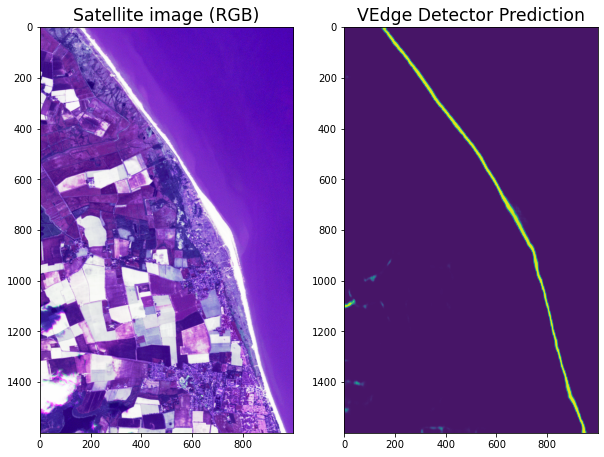

In [13]:
pred = model.predict(X=dataset,provider='Planet')